In [1]:
!ls /keyakizaka_mining/

data  model  result  secret  tools


In [2]:
!pip install opencv-python
!pip install opencv-contrib-python

In [10]:
import argparse
import sys
import os

import datetime
import numpy as np
import cv2

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Parameters

PADDING = 0
CONF_THRESHOLD = 0.5
NMS_THRESHOLD = 0.4
IMG_WIDTH = 416
IMG_HEIGHT = 416

# Default colors
COLOR_BLUE = (255, 0, 0)
COLOR_GREEN = (0, 255, 0)
COLOR_RED = (0, 0, 255)
COLOR_WHITE = (255, 255, 255)
COLOR_YELLOW = (0, 255, 255)

# path

model_cfg = './cfg/yolov3-face.cfg'
model_weights = '/keyakizaka_mining/model/yoloface/model-weights/yolov3-wider_16000.weights'

In [4]:
# functions

def get_outputs_names(net):
    # Get the names of all the layers in the network
    layers_names = net.getLayerNames()
    return [layers_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

def refined_box(left, top, width, height):
    right = left + width
    bottom = top + height

    original_vert_height = bottom - top
    top = int(top + original_vert_height * 0.15)
    bottom = int(bottom - original_vert_height * 0.05)

    margin = ((bottom - top) - (right - left)) // 2
    left = left - margin if (bottom - top - right + left) % 2 == 0 else left - margin - 1
    right = right + margin

    # padding
    left -= PADDING
    top -= PADDING
    right += PADDING
    bottom += PADDING
    
    return left, top, right, bottom

def post_process(image_name, save_face_dir, frame, outs, conf_threshold, nms_threshold):
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the ones with high confidence scores.
    # Assign the box's class label as the class with the highest score.
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                center_x = int(detection[0] * frame_width)
                center_y = int(detection[1] * frame_height)
                width = int(detection[2] * frame_width)
                height = int(detection[3] * frame_height)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with lower confidences.
    save_imanames = []
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    for i in indices:
        box = boxes[i[0]]
        left, top, width, height = box[0], box[1], box[2], box[3]     
        if left < 0 or top < 0: continue
        if left + width > frame.shape[1] or top + height > frame.shape[0]: continue
        left, top, right, bottom = refined_box(left, top, width, height)
        save_imname = '%s/face%d_%s.png' % (save_face_dir, i[0], image_name) # 'facetest_%d.png' % i[0], frame[top:bottom,left:right]
        cv2.imwrite( save_imname, frame[top:bottom,left:right]) # save rectangle
        save_imanames.append( save_imname )
    return save_imanames

def save_detected_faceimages( image_path, image_name, save_face_dir ):
    cap = cv2.VideoCapture( image_path )

    has_frame, frame = cap.read()
    blob = cv2.dnn.blobFromImage(frame, 1 / 255, (IMG_WIDTH, IMG_HEIGHT), [0, 0, 0], 1, crop=False) # Create a 4D blob from a frame.

    net.setInput(blob) # Sets the input to the network
    outs = net.forward(get_outputs_names(net)) # Runs the forward pass to get output of the output layers

    post_process(image_name, save_face_dir, frame, outs, CONF_THRESHOLD, NMS_THRESHOLD) # Remove the bounding boxes with low confidence

    cap.release()
    return

def plot_image( image_path ):
    im = Image.open( image_path )
    im_list = np.asarray(im)
    plt.imshow(im_list)
    plt.show()
    return

def test_detected_faceimages( image_path, image_name, save_face_dir ):
   
    print( 'input image:' )
    plot_image( image_path )
    
    cap = cv2.VideoCapture( image_path )

    has_frame, frame = cap.read()
    blob = cv2.dnn.blobFromImage(frame, 1 / 255, (IMG_WIDTH, IMG_HEIGHT), [0, 0, 0], 1, crop=False) # Create a 4D blob from a frame.

    net.setInput(blob) # Sets the input to the network
    outs = net.forward(get_outputs_names(net)) # Runs the forward pass to get output of the output layers

    save_imanames = post_process(image_name, save_face_dir, frame, outs, CONF_THRESHOLD, NMS_THRESHOLD) # Remove the bounding boxes with low confidence

    cap.release()
    
    print( 'detected face images', len(save_imanames) )
    for simage_path in save_imanames:
        plot_image( simage_path )
        
    return

In [11]:
# Give the configuration and weight files for the model and load the network using them.

net = cv2.dnn.readNetFromDarknet(model_cfg , model_weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [12]:
test_image_path = './samples/test_risa.jpg'

input image:


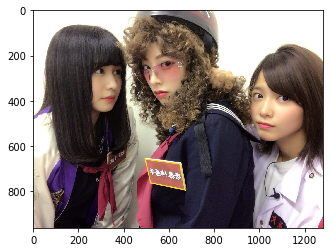

detected face images 3


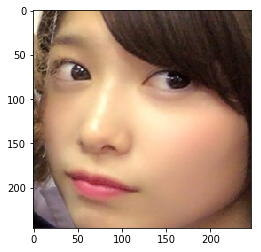

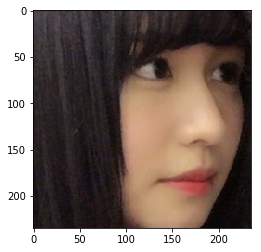

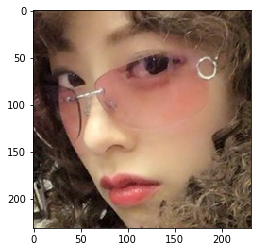

In [13]:
test_detected_faceimages( test_image_path, 'test','./outputs/' )